In [ ]:
from torchvision import datasets # Importando os Datasets necessários para o treinamento
from torchvision.transforms import ToTensor

# O Torchvision é uma biblioteca que fornece várias ferramentas úteis para o processamento de imagens
# incluindo conjuntos de dados populares para treinamento de modelos de visão computacional.

In [ ]:
# MNIST é um dataset que contém várias imagens de números escritos à mão (de 0 a 9).
dados_treinamento = datasets.MNIST( # Separando os dados para treinamento do Modelo
    root = 'data', # Indica onde os dados serão armazenados
    train = True, # Especifica que deve ser o conjunto de imagens de Treinamento
    transform = ToTensor(), # Transforma as imagens em um conjunto numérico que é processável pelo Pytorch
    download = True, # Indica que caso o dataset não exista no diretório, deve ser baixado.
)

dados_teste = datasets.MNIST( # Separando os Dados para Testar a acurácia do Modelo
    root = 'data',
    train = False, # Especifica que deve ser o conjunto de imagens de Teste
    transform = ToTensor(),
    download = True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 599kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.13MB/s]


In [ ]:
# VERIFICANDO O DATASET DE TREINAMENTO
print(dados_treinamento)

# VERIFICANDO O TAMANHO DAS IMAGENS
print(dados_treinamento.data.shape) # 28x28 = 784 pixels, ou no caso, informações de 0-1 (preto - branco)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


In [ ]:
# VERIFICANDO O DATASET DE TESTES
print(dados_teste)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
# Importando a Função para carregar os dados no Modelo
from torch.utils.data import DataLoader # O data Loader permite carregar os Dados no modelo em Lote, além de abstrair muitas configurações que de outro modo seriam manuais

loaders = { # Configurando os Loaders que vão carregar os Dados
    # Loader de Dados de Treinamento
    'treinamento': DataLoader(dados_treinamento, # De onde ele deve retirar os dados
                              batch_size=100, # O tamanho do Lote que será enviado para treinamento por iteração
                              shuffle=True, # Permite o Embaralhamento dos dados antes de enviar ao modelo (Evita que o modelo aprenda a ordem dos dados)
                              num_workers=1,), # Quantidade de Threads
    # Loader de Dados de Testagem
    'teste': DataLoader(dados_teste,
                              batch_size=100,
                              shuffle=True,
                              num_workers=1,),
}

In [ ]:
# DEFININDO O MODELO E ARQUITETURA DA REDE NEURAL
import torch.nn as nn # Módulos e as funções para criar redes neurais. | nn = Neural Network
import torch.nn.functional as F # Funções de ativação, operações de pooling, etc. Essenciais para treinar os Modelos
import torch.optim as optim # Biblioteca para otimizadores, que ajudam a ajustar os parâmetros da rede durante o treinamento.

class Modelo(nn.Module):
  # Método Construtor da Classe
  def __init__(self):
    super(Modelo,self).__init__() # Estamos chamando o hama o construtor da classe base nn.Module para que a nossa classe Modelo tenha suas funcionalidades.

    # Definindo as camadas da rede neural (Arquitetura)
      ```
      Breve Explicação
        1. As camadas convolucionais recebem dados estruturados em grades
        elas são responváveis por extrair caracteristicas das imagens,
        elas detectam padrões e elas não analisam toda a imagem de uma vez,
        mas por partes, por pequenas regiões da imagem.
      ```

    self.conv_layer1 = nn.Conv2d(1,10,kernel_size=5) # 1 = Um canal de entrada, apenas pois é escala de cinza | 10 = Aplicaremos 10 filtros para tentar encontrar 10 mapas de Caracteristicas.
    self.conv_layer2 = nn.Conv2d(10,20,kernel_size=5) # 10 = Justamente os 10 mapas de caracteristicas buscadas anteriormente | 20 = 20 filtros em cima das 10 entradas que chegaram da primeira camada
    # Kernel_size = 5, significa que vamos olhar em regiões de 5x5 para cada imagem e realizar a operação de Convolução nela

    self.conv_layer_drop = nn.Dropout2d() # Desligar aleatoriamente algumas conexões da rede durante o treinamento para evitar Overfitting, ao impedir que o modelo dependa demais de um mapa de caracteristica
    self.fc1 = nn.Linear(320,50) # dense layer in tense flow
    self.fc2 = nn.Linear(50,10)

     ```
      Breve Explicação 2
        1. Essa rede em questão tem 2 Camadas Convolucionais, 1 Camada de Regularização (Dropout)
        e 2 camadas 'fully conected', nessa sequência
      ```

  def forward(self, x):
    # X = Dados
    # Tensor = Array Multidimensional de Dados Numéricos Otimizado para Processamento em GPU
    x = F.relu(F.max_pool2d(self.conv_layer1(x), 2)) # A função de Pooling vai olhar o mapa de Caracteristicas e Pegar o maior. (há outros tipos)
    x = F.relu(F.max_pool2d(self.conv_layer_drop(self.conv_layer2(x)), 2)) # Aplicamos os dados na camada 2 -> Aplicamos o Dropout na Saida dos Dados -> Aplicamos outro Pooling antes de enviar para a próxima camada
    x = x.view(-1, 320) # Transforma os valores de saida da ultima camada (Tensor 3D) e tranforma em um vetor númerico que pode ser processado pelas camadas "Fully Connecteds"
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training) # Aplica o Dropout apenas no treinamento
    x = self.fc2(x)

    return F.softmax(x) # Transforma as saidas do modelo em probabiblidades de 0 -1

In [ ]:
import torch
#  Se uma GPU com CUDA Cores estiver disponível, usar para acelerar processamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Modelo().to(device) # Carregar o modelo no dispositivo disponivel

# Lr = Learning Rate
optimizer = optim.Adam(model.parameters(), lr=0.001) # Utiliza o Algoritmo ADAM para atualizar os pesos durante treinamento
# Aqui dizemos ao otimizador para trabalhar em cima dos parametros do modelo
# Lr é a taxa de aprendizado e controla o "tamanho" dos ajustes feitos nos pesos se for muito alta causará instabilidade

loss_function = nn.CrossEntropyLoss() # função que calcula a diferença entre a previsão do modelo e o resultado esperado


# Definindo as Funções de Treinamento e Teste
def train(epoch): # Função para treinar o Modelo
  model.train() # Coloca o modelo em modo de Treinamento
  # Iteração pelos Batchs de Dados de 100 em 100 usando o Loader de Treinamento
  for batch_idx, (data,target) in enumerate(loaders['treinamento']): # Batch_idx = Index do Batch atual | Data = A imagem enviada | Target = A previsão Correta/esperada
    data,target = data.to(device), target.to(device) # CPU ou GPU
    optimizer.zero_grad() # Zerando os Gradientes, pois o Pytorch faz isso automáticamente | Gradientes = os valores que indicam como os parâmetros do modelo devem ser ajustados
    output = model(data) # Predição feita
    loss = loss_function(output,target) # Comparar com o resultado correto e calcular o erro
    loss.backward() # Backpropagation - Calcular os Gradientes
    optimizer.step() # Atualizar Parametros do Modelo
    # Função para Controlar verificar o Progresso (A cada 20 Lotes - 2000 itens)
    if batch_idx % 20 == 0:
      print(f"Epoch de Treinamento : {epoch} [{batch_idx * len(data)} / {len(loaders['treinamento'].dataset)}] ({100. * batch_idx /len(loaders['treinamento']):.0f}%) \t % de Erro {loss.item():.6f}")


def test():
  model.eval() # Coloca o modelo em modo de Avaliação
  test_loss = 0 # Variável para acumular o valor da perda em todas as amostras do conjunto de teste.
  correct = 0 # Contador de quantas previsões o modelo acertou.

  with torch.no_grad(): #  desativa o cálculo de gradientes
    for data, target in loaders['teste']: # Carrega os Dados de teste
      data, target = data.to(device), target.to(device)
      output = model(data) # Recebe a Saida
      test_loss += loss_function(output,target).item() # Somar ao Valor de Perda
      prediction = output.argmax(dim = 1,keepdim = True) # Receber o Valor Previsto pelo modelo
      correct += prediction.eq(target.view_as(prediction)).sum().item() # Analisar se está correto

  test_loss /= len(loaders['teste'].dataset) # Calcular a média de Perda
  print(f"Set de Teste: Perda Média{test_loss:.4f}: , Acurácia: {correct}/{len(loaders['teste'].dataset)} ({100. * correct / len(loaders['teste'].dataset):.0f}%\n)")


In [ ]:
# Começando o Treinamento

for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-8-f0309ddd8361>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch de Treinamento : 1 [0 / 60000] (0%) 	 2.302440
Epoch de Treinamento : 1 [2000 / 60000] (3%) 	 2.287389
Epoch de Treinamento : 1 [4000 / 60000] (7%) 	 2.113532
Epoch de Treinamento : 1 [6000 / 60000] (10%) 	 2.037616
Epoch de Treinamento : 1 [8000 / 60000] (13%) 	 1.894850
Epoch de Treinamento : 1 [10000 / 60000] (17%) 	 1.855364
Epoch de Treinamento : 1 [12000 / 60000] (20%) 	 1.806999
Epoch de Treinamento : 1 [14000 / 60000] (23%) 	 1.799281
Epoch de Treinamento : 1 [16000 / 60000] (27%) 	 1.757761
Epoch de Treinamento : 1 [18000 / 60000] (30%) 	 1.685510
Epoch de Treinamento : 1 [20000 / 60000] (33%) 	 1.787552
Epoch de Treinamento : 1 [22000 / 60000] (37%) 	 1.710891
Epoch de Treinamento : 1 [24000 / 60000] (40%) 	 1.721472
Epoch de Treinamento : 1 [26000 / 60000] (43%) 	 1.689368
Epoch de Treinamento : 1 [28000 / 60000] (47%) 	 1.749052
Epoch de Treinamento : 1 [30000 / 60000] (50%) 	 1.705188
Epoch de Treinamento : 1 [32000 / 60000] (53%) 	 1.653194
Epoch de Treinamento : 1 

prediction 7


<ipython-input-8-f0309ddd8361>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


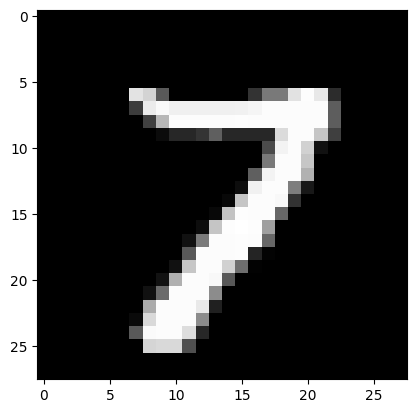

In [ ]:
import matplotlib.pyplot as plt  # Importa a biblioteca para visualização de gráficos

# Colocando o modelo no modo de avaliação (avaliação desativa dropout e outras funções de treinamento)
model.eval()

# Vamos pegar um único exemplo de dados de teste, no caso, o índice 34 do conjunto de dados de teste
data, target = dados_teste[34]  ## Pegamos um valor aleatório do Dataset de testes

# Adiciona uma dimensão extra para compatibilizar com o formato esperado pelo modelo
# Isso é necessário porque o modelo espera a entrada em forma de batch, mesmo que seja um único exemplo.
data = data.unsqueeze(0).to(device)  # .to(device) garante que os dados sejam movidos para a GPU ou CPU conforme configurado

# Passa a imagem através do modelo para fazer a predição
output = model(data)  # O modelo realiza a predição para a imagem de entrada

# Extrai a classe com a maior probabilidade de predição (predição do modelo)
prediction = output.argmax(dim=1, keepdim=True).item()  # Obtém o índice da maior probabilidade

# Imprime a predição para o usuário ver
print(f"prediction {prediction}")  # Mostra o número que o modelo acha que é a imagem

# Prepara a imagem para exibição: removemos a dimensão do batch e do canal (deixando apenas a imagem 28x28)
image = data.squeeze(0).squeeze(0).cpu().numpy()  # Convertendo para um array NumPy para usar com matplotlib

# Exibe a imagem em escala de cinza
plt.imshow(image, cmap='gray')  # Exibe a imagem em tons de cinza

# Mostra a imagem na tela
plt.show()
